In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import vector_to_parameters, parameters_to_vector
import matplotlib.pyplot as plt
import numpy as np
import random

from src.models import LeNet
from models import *

SEED = 42

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


def train(model, device, train_loader, optimizer, epoch):
    log_interval = 100
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [2]:
def modify_parameter(model, i, value):
    vec = parameters_to_vector(model.parameters())
    vec[i] = value
    vector_to_parameters(vec, model.parameters())
    
def calculate_ll(full_train_loader, model):
    test_loss = 0
    test_good = 0
    with torch.no_grad():
        for data, target in full_train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += -F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            test_good += pred.eq(target.view_as(pred)).sum().item()
    return test_loss, test_good

class N(nn.Module):
    def __init__(self):
        super().__init__()
        # self.log_A = torch.nn.Parameter(torch.tensor(0.), requires_grad=True)
        self.mu = torch.nn.Parameter(torch.tensor(0.), requires_grad=True)
        self.log_s = torch.nn.Parameter(torch.tensor(0.), requires_grad=True)
        self.pi = torch.tensor(np.pi, requires_grad=False)
    def forward(self, x):
        # A = torch.exp(self.log_A)
        s = torch.exp(self.log_s)
        x = 1/(s*(2*self.pi)**(1/2)) * torch.exp(-((x - self.mu)/s)**2)
        return x
    
def fit_N(x, p):
    dist = N()
    optim = torch.optim.SGD(dist.parameters(), lr=0.4)
    for _ in range(1000):
        optim.zero_grad()
        xt = torch.from_numpy(x)
        out = dist(xt)
        loss = torch.mean((out - torch.from_numpy(p))**2)
        loss.backward()
        optim.step()
    
    return out.cpu().detach().numpy()

In [3]:
batch_size = 128
test_batch_size = 128
lr = 0.001
gamma = 0.7
epochs = 20
device = 'cuda:0'
train_limit = int(1e6)

# model = Net().to(device)
# model = LeakyNet().to(device)
# model = FCNNet().to(device)
# model = AbsNet().to(device)
model = LeNet(1,10, 1).to(device)


train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if 'cuda' in device:
    cuda_kwargs = {'num_workers': 16,
                   'pin_memory': True,
                   'persistent_workers': True,
                   }
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_dataset = datasets.MNIST('../datasets', train=True, download=True,
                   transform=transform)
test_dataset = datasets.MNIST('../datasets', train=False,
                   transform=transform)

# train_dataset = datasets.FashionMNIST('../data', train=True, download=True,
#                    transform=transform)
# test_dataset = datasets.FashionMNIST('../data', train=False,
#                    transform=transform)

train_dataset.data = train_dataset.data[:train_limit]
train_dataset.targets = train_dataset.targets[:train_limit]


train_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

Net has: 65586 parameters


In [5]:
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

torch.save(model.state_dict(), "mnist_lenet.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.027439
Train Epoch: 1 [12800/60000 (21%)]	Loss: -8.602041
Train Epoch: 1 [25600/60000 (43%)]	Loss: -17.691010
Train Epoch: 1 [38400/60000 (64%)]	Loss: -26.414566
Train Epoch: 1 [51200/60000 (85%)]	Loss: -35.063358

Test set: Average loss: -40.7942, Accuracy: 980/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -40.898727
Train Epoch: 2 [12800/60000 (21%)]	Loss: -46.789249


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/ksawery/.pyenv/versions/3.8.11/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ksawery/.pyenv/versions/3.8.11/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ksawery/.cache/pypoetry/virtualenvs/bayesian-AIC1jy8r-py3.8/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/ksawery/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/home/ksawery/.cache/pypoetry/virtualenvs/bayesian-AIC1jy8r-py3.8/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/home/ksawery/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
   

KeyboardInterrupt: 

65586

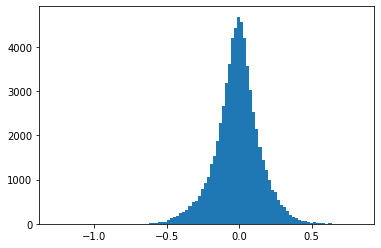

In [4]:
model.load_state_dict(torch.load("mnist_cnn.pt"))
model = model.to(device)
model.eval()
full_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2**10, num_workers=16)
original_parameters = parameters_to_vector(model.parameters()).detach().clone()
plt.hist(original_parameters.cpu().numpy(), bins=100)
len(original_parameters)

In [5]:
def plot_1d(df, val, i, train_limit):
#     print(df)
    good = df[:,2].astype('float') / train_limit
    logp = df[:,1]
    p = np.exp(logp - np.max(logp))
    plt.figure(figsize=(15,5))
    ax = plt.subplot(1,1,1)
    ax.plot(df[:,0], p);
    ax.axvline(x=val, c='r')
    p_N = fit_N(df[:,0], p)
    ax.plot(df[:,0], p_N, alpha=0.7);
    ax.plot(df[:,0], good, alpha=0.7);
    plt.ylim(0.0, 1.05)
    plt.title(f"i:{i}, val: {val}")
    plt.show()

In [6]:
i = 123
length = len(original_parameters)
inds = np.random.choice(np.arange(length), 10)

# inds = [0,1, length - 1, length - 2]
# inds = [length - 1, length - 2]

15795 tensor(-0.0316)
..................................................

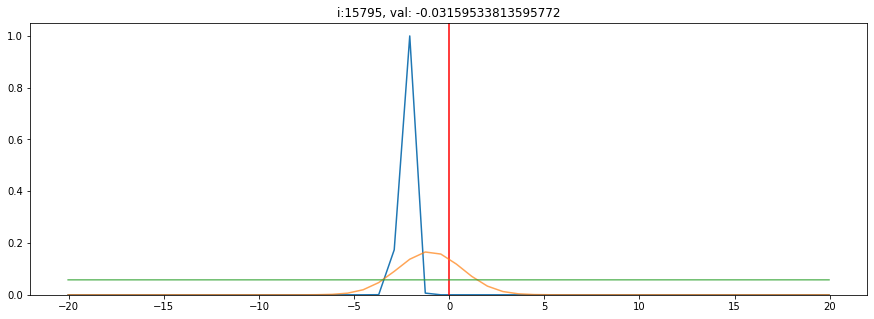

860 tensor(-0.3152)
...............................

In [ ]:
window = 20
rate = 50

for idx, i in enumerate(inds, 1):
    val = original_parameters[i].cpu()
    print(i, val)
    vector_to_parameters(original_parameters, model.parameters())
    df = []
    for value in torch.linspace(val-window, val+window, rate, device=device):
        print('.', end='')
        modify_parameter(model, i, value)
        ll, good = calculate_ll(full_train_loader, model)
        df.append((value, ll, good))
    df = torch.tensor(df).cpu().numpy()
    plot_1d(df, val, i, train_limit)

In [10]:
def plot_2d(df, val1, i1, val2, i2, train_limit):
    good = df[:,3].astype('float') / train_limit
    logp = df[:,2]
    p = np.exp(logp - np.max(logp))
    length = np.sqrt(len(p))
    assert int(length) == length
    length = int(length)
#     X, Y = np.meshgrid(df[:,0], df[:,1])
#     plt.contourf(X, Y, p.reshape(length, length))
    plt.contourf(p.reshape(length, length), levels=np.linspace(0,1,20))
    plt.colorbar()
    plt.show()

In [11]:
n_plot = 50
inds = np.random.choice(np.arange(length), 2 * n_plot, replace=False)
inds = zip(inds[0:n_plot], inds[n_plot:])

26479 tensor(0.1011, device='cuda:0')
44230 tensor(-0.0641, device='cuda:0')
....................

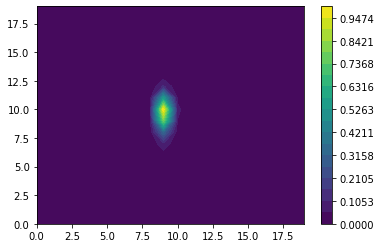

26168 tensor(0.0811, device='cuda:0')
30487 tensor(0.0345, device='cuda:0')
....................

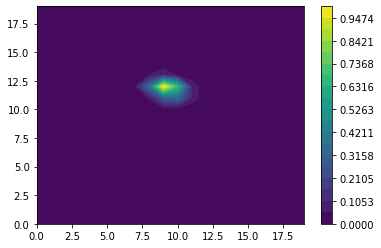

3647 tensor(-0.0325, device='cuda:0')
9019 tensor(-0.0865, device='cuda:0')
.....

In [ ]:
window = 10
rate = 20
model.to(device)
for idx, (i1, i2) in enumerate(inds, 1):
    val1 = original_parameters[i1]
    val2 = original_parameters[i2]
    print(i1, val1)
    print(i2, val2)
    vector_to_parameters(original_parameters, model.parameters())
    df = []
    for value1 in torch.linspace(val1-window, val1+window, rate, device=device):
        modify_parameter(model, i1, value1)
        for value2 in torch.linspace(val2-window, val2+window, rate, device=device):
            modify_parameter(model, i2, value2)
            ll, good = calculate_ll(full_train_loader, model)
            df.append((value1, value2, ll, good))
        print('.', end='')
    df = torch.tensor(df).cpu().numpy()
    plot_2d(df, val1.cpu(), i1, val2.cpu(), i2, train_limit)